# Свёрточные нейронные сети (СНС)

## Задание
Реализовать и обучить (с нуля) СНС для задачи классификации изображений на датасете CIFAR-10 <br>
Библиотеки: [Python, Tensorflow]

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

In [2]:
(train_x, train_y), (test_x, test_y) = tf.keras.datasets.cifar10.load_data()

170508288/170498071 [==============================] - 2s 0us/step


In [3]:
classes = ['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

In [4]:
train_x = train_x.astype(np.float32) / 255.0
test_x = test_x.astype(np.float32) / 255.0

train_y = train_y.reshape(-1).astype(np.int32)
test_y = test_y.reshape(-1).astype(np.int32)

print(train_x.shape, train_x.dtype)
print(test_x.shape, test_x.dtype)
print(train_y.shape, train_y.dtype)
print(test_y.shape, test_y.dtype)

(50000, 32, 32, 3) float32
(10000, 32, 32, 3) float32
(50000,) int32
(10000,) int32


## Визуализация датасета CIFAR-10

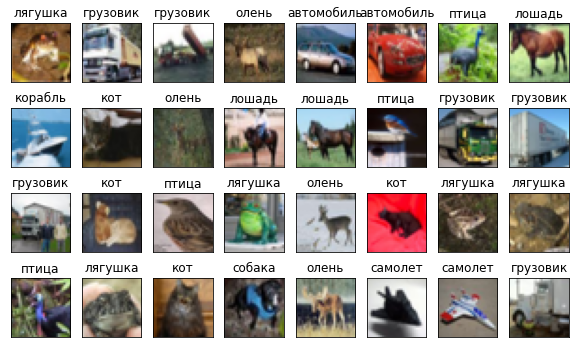

In [5]:
some_samples = train_x[:32, ...]
some_labels = train_y[:32]

fig = plt.figure(figsize=(10, 6))
for j in range(some_samples.shape[0]):
    ax = fig.add_subplot(4, 8, j+1)
    ax.imshow(some_samples[j,...])
    ax.title.set_text(classes[some_labels[j]])
    plt.xticks([]), plt.yticks([])
plt.show()

In [6]:
# Выполним визуализацию данных. Посмотрим что из этого получится. Как выполнять визуализацию?
# range

## Создание пайплайна данных

In [20]:
NUM_EPOCHS = 7
BATCH_SIZE = 64

num_classes = len(classes)

train_ds = tf.data.Dataset.from_tensor_slices((train_x, train_y))
train_ds = train_ds.shuffle(buffer_size=train_x.shape[0])
train_ds = train_ds.repeat(NUM_EPOCHS)
train_ds = train_ds.batch(BATCH_SIZE)

In [21]:
class Model(tf.keras.Model):
    
    def __init__(self):
        super(Model, self).__init__()
        
        self.conv1 = tf.keras.layers.Conv2D(32, (3, 3), input_shape=(32, 32, 3), activation='relu', padding='same')
        self.conv2 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding='same')
        self.conv3 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.conv4 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding='same')
        self.conv5 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')
        self.conv6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding='same')
        self.batch_norm_1 = tf.keras.layers.BatchNormalization()
        self.batch_norm_2 = tf.keras.layers.BatchNormalization()
        self.batch_norm_3 = tf.keras.layers.BatchNormalization()
        self.batch_norm_4 = tf.keras.layers.BatchNormalization()
        self.batch_norm_5 = tf.keras.layers.BatchNormalization()
        self.batch_norm_6 = tf.keras.layers.BatchNormalization()

        self.max_pool = tf.keras.layers.MaxPooling2D((2, 2), (2, 2))
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(256, activation='relu')
        self.fc2 = tf.keras.layers.Dense(128, activation='relu')
        self.fc3 = tf.keras.layers.Dense(num_classes, activation=None) # Прикольно, что здесь не используется softmax.
        self.dropout = tf.keras.layers.Dropout(0.1)
           
    def call(self, inp): # Динамический граф.
        out = self.conv1(inp)
        # out = self.batch_norm_1(out)
        out = self.conv2(out)
        out = self.batch_norm_2(out)
        out = self.max_pool(out)

        out = self.conv3(out)
        # out = self.batch_norm_3(out)
        out = self.conv4(out)
        out = self.batch_norm_4(out)
        # out = self.dropout(out)
        out = self.max_pool(out)

        out = self.conv5(out)
        # out = self.batch_norm_5(out)
        # out = self.dropout(out)
        out = self.conv6(out)
        out = self.batch_norm_6(out)
        # out = self.dropout(out)
        out = self.max_pool(out)

        out = self.flatten(out)
        out = self.fc1(out)
        out = self.dropout(out)
        out = self.fc2(out)
        out = self.dropout(out)
        out = self.fc3(out)
        
        return out
    
model = Model()

## Функция потерь и функция вычисления точности

In [22]:
def loss(logits, labels):
    return tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(
        logits=logits, labels=labels))

def accuracy(logits, labels):
    predictions = tf.argmax(logits, axis=1, output_type=tf.int32) # Превращение из категории в число производится здесь.
    return tf.reduce_mean(tf.cast(tf.equal(predictions, labels), dtype=tf.float32))

## Подготовка к обучению

In [23]:
LEARNING_RATE = 0.001

optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)

In [24]:
loss_list = []
accuracy_list = []

## Цикл обучения модели

In [25]:
%%time

for iteration, (images, labels) in enumerate(train_ds):
    
    # Forward
    with tf.GradientTape() as tape:
        logits = model(images) # Модель будет возврящать не массив чисел а тензор из логитов. 
        loss_value = loss(logits, labels)
        
    # Backward
    grads = tape.gradient(loss_value, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    # Calc and display loss/accuracy
    if iteration % 500 == 0:
        test_logits = model(test_x[:512, ...])
        accuracy_value = accuracy(test_logits, test_y[:512, ...])
        
        print("[%5d] Accuracy: %5.2f %%" % (
            iteration, accuracy_value.numpy()*100))

        loss_list.append(loss_value)
        accuracy_list.append(accuracy_value)

        if accuracy_value > 0.79:
          optimizer.learning_rate = 0.0001
        
        # with writer.as_default():
        #     tf.summary.scalar('accuracy', accuracy_value, iteration)
        #     tf.summary.scalar('loss', loss_value, iteration)

[    0] Accuracy:  9.96 %
[  500] Accuracy: 49.61 %
[ 1000] Accuracy: 65.23 %
[ 1500] Accuracy: 72.07 %
[ 2000] Accuracy: 74.02 %
[ 2500] Accuracy: 75.59 %
[ 3000] Accuracy: 78.12 %
[ 3500] Accuracy: 74.02 %
[ 4000] Accuracy: 79.10 %
[ 4500] Accuracy: 82.42 %
[ 5000] Accuracy: 81.64 %
CPU times: user 2min 31s, sys: 1.41 s, total: 2min 32s
Wall time: 2min 31s


## Оценка качества модели

In [26]:
%%time
test_logits = model(test_x)

CPU times: user 8.67 s, sys: 18 ms, total: 8.68 s
Wall time: 8.73 s


In [27]:
loss_value = loss(test_logits, test_y)
accuracy_value = accuracy(test_logits, test_y).numpy()

print(f"Final Loss: {loss_value:.4f}, Final Accuracy: {(accuracy_value * 100):.2f} %")

Final Loss: 0.7785, Final Accuracy: 79.40 %


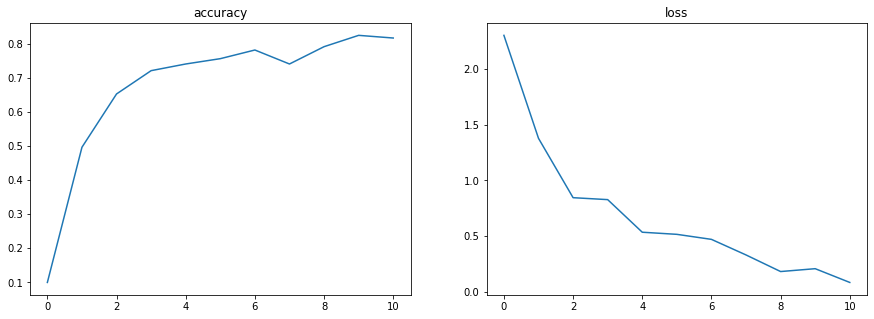

In [28]:
fig, ax = plt.subplots(ncols=2,nrows=1,figsize=(15, 5))
ax[0].plot(accuracy_list)
ax[0].title.set_text('accuracy')
ax[1].plot(loss_list)
ax[1].title.set_text('loss')
plt.show()

## Функция для инференса и отображения результата предсказания

In [29]:
def test_item(sample):
    
    logits = model(sample[None, ...])[0]
    prediction = tf.nn.softmax(logits)
    ans = np.argmax(prediction)
    
    fig = plt.figure(figsize=(12,4))

    ax = fig.add_subplot(1, 2, 1)
    ax.imshow(sample)
    plt.xticks([]), plt.yticks([])

    ax = fig.add_subplot(1, 2, 2)
    bar_list = ax.bar(np.arange(10), prediction, align='center')
    bar_list[ans].set_color('g')
    ax.set_xticks(np.arange(10))
    ax.set_xlim([-1, 10])
    ax.grid(True)

    plt.show()
    
    print('Predicted: {} ({})'.format(classes[ans],ans))

## Запуск предсказания для случайного изображения из CIFAR-10

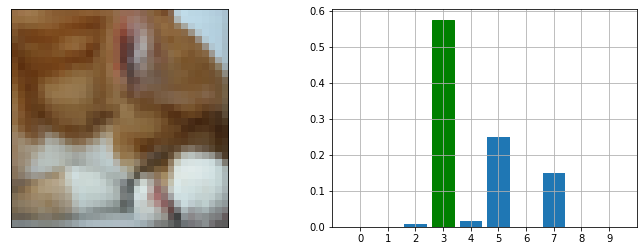

Predicted: кот (3)
True Answer: кот (3)


In [34]:
import random
idx = random.randint(0, test_x.shape[0])
sample = test_x[idx, ...]
test_item(sample)

print('True Answer: {} ({})'.format(classes[test_y[idx]],test_y[idx]))

In [31]:
#[0:'самолет', 1:'автомобиль', 2:'птица', 3:'кот', 4:'олень', 5:'собака', 6:'лягушка', 7:'лошадь', 8:'корабль', 9:'грузовик']